In [42]:
import numpy as np
import matplotlib.pyplot as plt

DT_SCALE = 0.5    # dt is allowed to be at most dx*DT_SCALE

class ConservativePDE:
    def __init__(self, a, b, num_cells, f):
        self.num_cells = num_cells
        self.f = f
        self.a = a
        self.b = b
        self.J = num_cells - 1
        self.dx = (b - a) / num_cells
        self.cell_centers = np.arange(a, b, self.dx) + self.dx / 2 # Stores the centers of the cells
        self.cell_boundaries = np.arange(a, b + self.dx, self.dx)
    
    def setIC(self, initial_condition):
        self.initial_condition = initial_condition

    def solveMUSCL(self, tmax):
        if not hasattr(self, 'initial_condition'):
            print("Set initial condition before solving.")
            return 1
        
        U = self.initialize_solution(tmax)

        for t in range(1, self.T+1):
            Ustar1 = self.MUSCLstep(U[t-1])
            Ustar2 = self.MUSCLstep(Ustar1)
            U[t] = (U[t-1] + Ustar2) / 2

        return U
    
    def MUSCLstep(self, Uprev):
        '''Polynomial Reconstruction'''
        S = self.getSlopes(Uprev) # Get slopes using slope-limiter method

        '''Numerical Flux Calculations'''
        F = self.getNumericalFluxes(Uprev, S)

        return Uprev - (self.dt / self.dx) * F

    def getNumericalFluxes(self, Uprev, S):
        alpha = self.findMaxCharacteristicSpeed(Uprev)

        '''Calculate right fluxes, F(j+1/2)'''
        U_tilde_minus = Uprev + S*self.dx / 2
        U_tilde_plus = np.roll(Uprev - S*self.dx / 2, -1)
        right_fluxes = self.LaxFriedrichsFlux(U_tilde_minus, U_tilde_plus, alpha)
        #right_fluxes = self.GodunovFlux(U_tilde_minus, U_tilde_plus)

        '''Calculate left fluxes, F(j-1/2)'''
        U_tilde_minus = np.roll(Uprev + S*self.dx / 2, 1)
        U_tilde_plus = Uprev - S*self.dx / 2
        left_fluxes = self.LaxFriedrichsFlux(U_tilde_minus, U_tilde_plus, alpha)
        #left_fluxes = self.GodunovFlux(U_tilde_minus, U_tilde_plus)

        return right_fluxes - left_fluxes

    def LaxFriedrichsFlux(self, a, b, alpha):
        return (self.f(a) + self.f(b))/2 + alpha*(a - b)/2
    
    def GodunovFlux(self, a, b):
        return self.f(a)

    '''Returns max{f'(u)} over all cells'''
    def findMaxCharacteristicSpeed(self, Uprev):
        df = self.f(Uprev) - self.f(np.roll(Uprev,1))
        du = Uprev - np.roll(Uprev,1)
        nonzero_indices = np.where(du != 0)[0]
        return np.max(np.abs(df[nonzero_indices] / du[nonzero_indices]))

    '''Takes in an array and calculates the slopes using the slope limiter method'''
    def getSlopes(self, Uprev):
        J = self.J
        S_forward = np.zeros((len(Uprev)))
        S_backward = np.zeros((len(Uprev)))
        
        for j in range(1, J):
            S_forward[j] = Uprev[j+1] - Uprev[j]
            S_backward[j] = Uprev[j] - Uprev[j-1]

        S_forward[0] = Uprev[1] - Uprev[0]
        S_backward[0] = Uprev[0] - Uprev[J]
        S_forward[J] = Uprev[0] - Uprev[J]
        S_backward[J] = Uprev[J] - Uprev[J-1]

        return np.array([self.minmod(S_forward[j], S_backward[j]) / self.dx for j in range(len(Uprev))])

    def minmod(self, a, b):
        if a > 0 and b > 0:
            return min(a,b)
        elif a < 0 and b < 0:
            return max(a,b)
        return 0

    def initialize_solution(self, tmax):
        self.set_time_attributes(tmax)
        U = np.zeros((self.T + 1, self.J + 1))
        ic_vectorized = np.vectorize(self.initial_condition)
        U[0] = ic_vectorized(self.cell_centers)
        return U

    def set_time_attributes(self, tmax):
        max_dt = self.dx * DT_SCALE
        self.T = int(np.ceil(tmax / max_dt))
        self.dt = tmax / self.T
        self.tarray = np.linspace(0, tmax, self.T + 1)

'''Main Script'''

p1_f = lambda x: np.pow(x,2) / 2

p1obj = ConservativePDE(0, 1, 100, p1_f)

p1obj.setIC(lambda x: 1 + np.sin(2*np.pi*x))

p1_sol_matrix = p1obj.solveMUSCL(1)

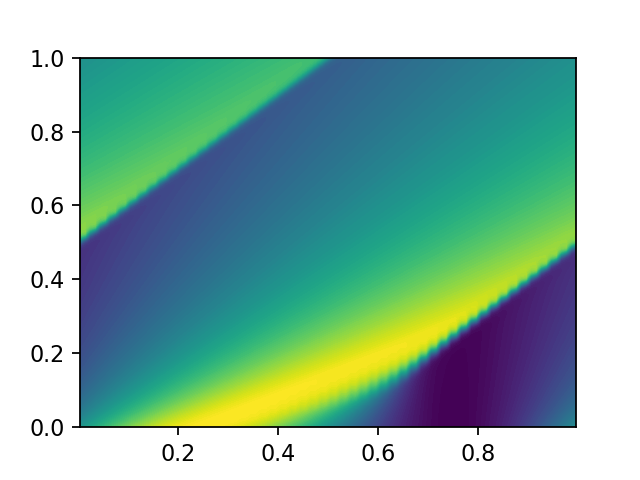

In [44]:
X, Y = np.meshgrid(p1obj.cell_centers, p1obj.tarray)

fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi=160)

ax.contourf(X, Y, p1_sol_matrix, levels=100)

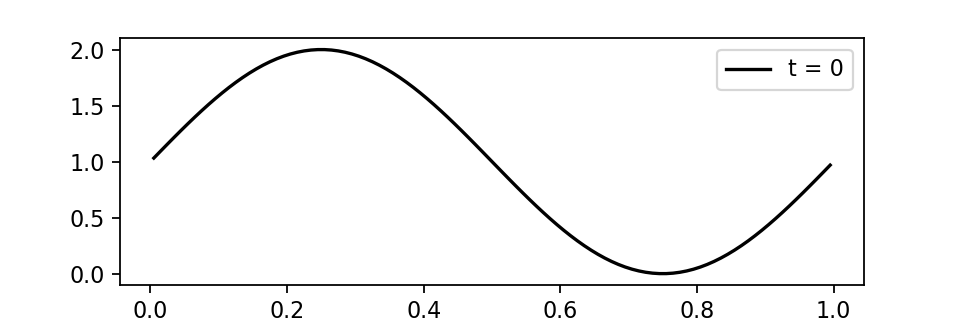

In [3]:
import matplotlib.animation as animation
%matplotlib ipympl

tarray = p1obj.tarray
cell_centers = p1obj.cell_centers

fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=160)

line1 = ax.plot(cell_centers, p1obj.initial_condition(cell_centers), label='t = 0', color='black')[0]
leg = ax.legend(loc='upper right')

skip = 5

def update(frame):
    # Update data in the plot
    line1.set_xdata(cell_centers)
    line1.set_ydata(p1_sol_matrix[frame*skip])
    # Update legend to show current time
    leg.get_texts()[0].set_text(f"t = {tarray[frame*skip]:.2f}")
    return (line1)

p1_anim = animation.FuncAnimation(fig=fig, func=update, frames=int(len(tarray) / skip), interval=10, blit=False)
plt.show()

save = True

if (save == True):
    writer = animation.PillowWriter(fps=30)
    saveStr = 'test.gif'
    p1_anim.save('Solution_GIFs/' + saveStr, writer=writer)

In [4]:
plt.close()

In [45]:
def p2_initial_condition(x):
    if isinstance(x, float):
        if 0 <= x and x < 1/3:
            return np.cos(6*np.pi*x)
        elif 1/3 <= x and x < 2/3:
            return 0
        elif 2/3 <= x and x <= 1:
            return np.cos(12*np.pi*x)
        else:
            return -1
    else:
        retArray = np.zeros((len(x)))
        for i in range(len(x)):
            if 0 <= x[i] and x[i] < 1/3:
                retArray[i] = np.cos(6*np.pi*x[i])
            elif 1/3 <= x[i] and x[i] < 2/3:
                retArray[i] = 0
            elif 2/3 <= x[i] and x[i] <= 1:
                retArray[i] = np.cos(12*np.pi*x[i])
            else:
                retArray[i] = -1

    return retArray
    
p2_f = lambda x: x

p2obj = ConservativePDE(0, 1, 100, p2_f)

p2obj.setIC(p2_initial_condition)

p2_sol_matrix = p2obj.solveMUSCL(10)

2001
2001


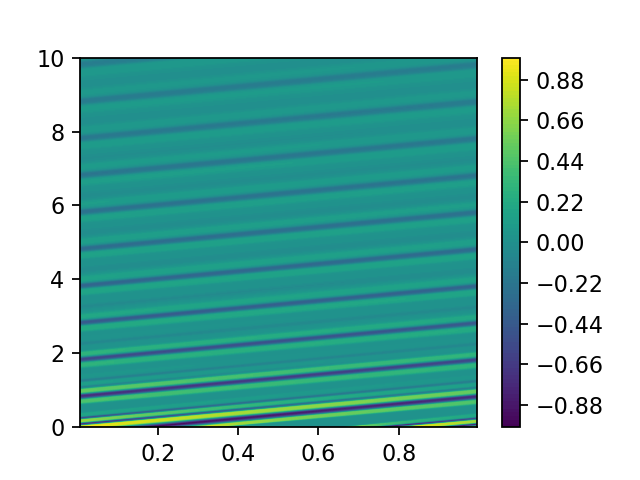

In [ ]:
X, Y = np.meshgrid(p2obj.cell_centers, p2obj.tarray)

fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi=160)

cfplot = ax.contourf(X, Y, p2_sol_matrix, levels=100)
fig.colorbar(cfplot)

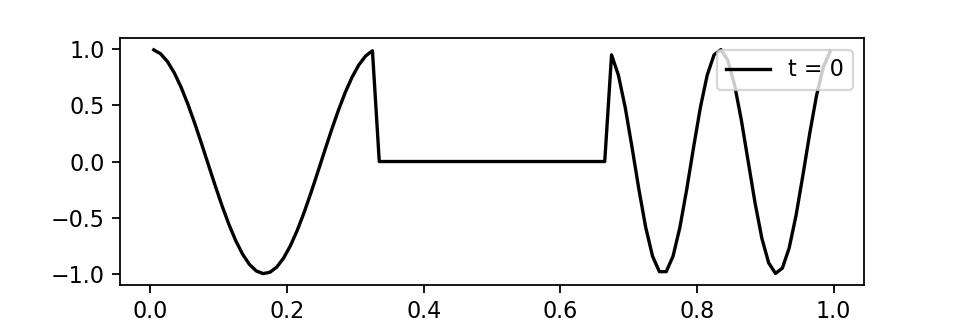

In [9]:
tarray = p2obj.tarray
cell_centers = p2obj.cell_centers

fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=160)

line1 = ax.plot(cell_centers, p2obj.initial_condition(cell_centers), label='t = 0', color='black')[0]
leg = ax.legend(loc='upper right')

skip = 10

def update(frame):
    # Update data in the plot
    line1.set_xdata(cell_centers)
    line1.set_ydata(p2_sol_matrix[frame*skip])
    # Update legend to show current time
    leg.get_texts()[0].set_text(f"t = {tarray[frame*skip]:.2f}")
    return (line1)

p2_anim = animation.FuncAnimation(fig=fig, func=update, frames=int(len(tarray) / skip), interval=10, blit=False)
plt.show()

save = False

if (save == True):
    writer = animation.PillowWriter(fps=30)
    saveStr = 'test.gif'
    p2_anim.save('Solution_GIFs/' + saveStr, writer=writer)

In [10]:
plt.close()